In [1]:
import rfcde
import numpy as np
import matplotlib.pyplot as plt

/usr/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


RFCDE extends to multiple response variables to estimate joint conditional densities.  Consider data from the following model

\begin{eqnarray}
X &\sim& U(0, 1) \\
Z_{1} &\sim& U(0, X) \\
Z_{2} &\sim& U(X, Z_{1})
\end{eqnarray}

This exhibits dependence not only between the responses and the covariates, but also between the responses themselves. Thus merely estimating the univariate conditional densities would lose the information about the dependence between $Z_{1}$ and $Z_{2}$.

In [2]:
np.random.seed(42)

def generate_data(n):
    x = np.random.uniform(0, 1, (n, 1))
    z1 = np.random.uniform(0, x[:,0], n)
    z2 = np.random.uniform(z1, x[:,0], n)
    return x, np.array([z1, z2]).T

n_train = 10000
x_train, z_train = generate_data(n_train)
x_test = np.array([0.3, 0.6, 0.9])

## Training
Training is the same as for the univariate case.  A tensor basis is used for the density estimates at each node; you can specify the number of basis functions for each dimension or just specify a single number which is applied to every dimension.  Note that this scales like $n^d$ for $n$ basis functions in $d$ dimensions.

In [3]:
n_trees = 100
mtry = 1
node_size = 20
n_basis = [15, 15] # or 15

forest = rfcde.RFCDE(n_trees=n_trees, mtry=mtry, node_size=node_size, n_basis=n_basis)
forest.train(x_train, z_train)

## Prediction
Prediction requires a multivariate grid of points at which to evaluate the density. Bandwidths can be specified by a covariance matrix, a float (which scales the identity covariance) or a string (see documentation for details).

In [4]:
bandwidth = 0.05
n_grid = 30
z1, z2 = np.meshgrid(np.linspace(0, 1, n_grid),
                     np.linspace(0, 1, n_grid))
z_grid = np.array([z1.flatten(), z2.flatten()]).T
x_test = np.array([0.3])
density = forest.predict(x_test, z_grid, bandwidth)

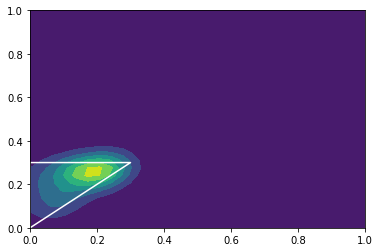

In [5]:
plt.contourf(np.linspace(0, 1, n_grid),
            np.linspace(0, 1, n_grid),
            density.reshape((n_grid, n_grid)))
plt.plot([0, x_test, 0, 0], [0, x_test, x_test, 0], color='white')
plt.show()